# Imports

In [2]:
%matplotlib ipympl

In [3]:
import numpy as np
import math
import scipy
import py3nj
import pandas as pd
import matplotlib.pyplot as plt


# Finding the Hamiltonian

The Hamiltonian is given by the kinetic energy of a rigid rotor, plus the interaction of the dipole with the electric field.

$$ H = \frac{L^2}{2I} + \vec{d}\cdot\vec{E} $$

Noting that *m* is a good quantum number as azimuthal symmetry remains, our approach for this problem will be to chose a value of m, and then utilize a finite basis of spherical harmonics, with *l* starting at *m*, to compute the hamiltonian matrix:

$$ H_{ij} (m)= <i m|H|j m> $$

Then we will diagonalize this matrix to find its eigenvalues, yielding the new energies of the system. The eigenvectors will be used to find the probability density functions of the new system.

In [4]:
def get_H_ijm_E_field(i, j, m):
    # This function returns H'[i,j], the contribution of the Electric field
    # to the hamiltonian, for a given value of m
    #
    # i is the l value of the bra
    # j is the l value of the ket
    # m is the lz value shared by the bra and ket

    if (1-i-m) % 2 == 0:
        c = 1
    else:
        c = -1
    return math.sqrt(4*math.pi/3) * c * math.sqrt(2*j+1) * py3nj.wigner3j(2*i, 2, 2*j, 2*m, 0, -2*m)


In [5]:
def find_H(B, d, E, m = 0, dim = 10):
  # B is the rotational constant
  # d is the molecular dipole moment
  # E is the electric field strength
  # m is the projection of angular momentum
  # dim is the dimension of the basis for the hamiltonian

  # Initialize Hamiltonian matrix
  H = np.zeros((dim,dim))

  # Fill Hamiltonian matrix with term by term 
  for i in range(dim):
    for j in range(i,dim):

      E_term = get_H_ijm_E_field(i+abs(m), j+abs(m), m)

      if i == j:
        H[i][j] = d*E*E_term + (j+abs(m))*(j+abs(m)+1)*B
      else:
        H[i][j] = d*E*E_term
        H[j][i] = d*E*np.conjugate(E_term)
  return H

In [6]:
def get_eigenstates_for_E_range(E_min, E_max, E_step, dim, B, d, m):
  # This method returns a dictionary which will contain dim arrays within it, each of
  # which contains the (eigenvalue, eigenvector) tuples corresponding to an
  # electric field value.
  
  Efield_eigenstates = {}
  for E in range(E_min,E_max,E_step):
    H = find_H(B,d,E,m,dim)
    eigenstates = scipy.linalg.eig(H)
    eigenstates = zip(np.real(eigenstates[0]), eigenstates[1])
    Efield_eigenstates['E='+str(E)] = (sorted(eigenstates, key=lambda x: (x[0])))
  return Efield_eigenstates

In [7]:
dim = 100    # dimension of the basis for the hamiltonian
m = 0       # value of mj quantum number

B = 1       # Rotational constant of the molecule
d = 1       # Dipole moment of the molecule

In [8]:
Efield_eigenstates = get_eigenstates_for_E_range(E_min = 0, E_max = 30, E_step = 1, dim = dim, B=B, d = d, m = m)
#Efield_eigenstates_worse = get_eigenstates_for_E_range(E_min = 0, E_max = 30, E_step = 1, dim = int(dim*2), I = I, d = d, h = h, m = m)

In [9]:
eigenvalues = [[value[0] for value in array] for array in Efield_eigenstates.values()]
#eigenvalues_worse = [[value[0] for value in array] for array in Efield_eigenstates_worse.values()]
eigenvectors = [[value[1] for value in array] for array in Efield_eigenstates.values()]

In [10]:
num_to_plot = 10

In [11]:
first_10_eigenvalues = [eigen_list[0:num_to_plot] for eigen_list in eigenvalues]
#first_10_eigenvalues_worse = [eigen_list[90:90+num_to_plot] for eigen_list in eigenvalues_worse]

In the plot below we see the Von-Neuman Wigner non-crossing rule at play!

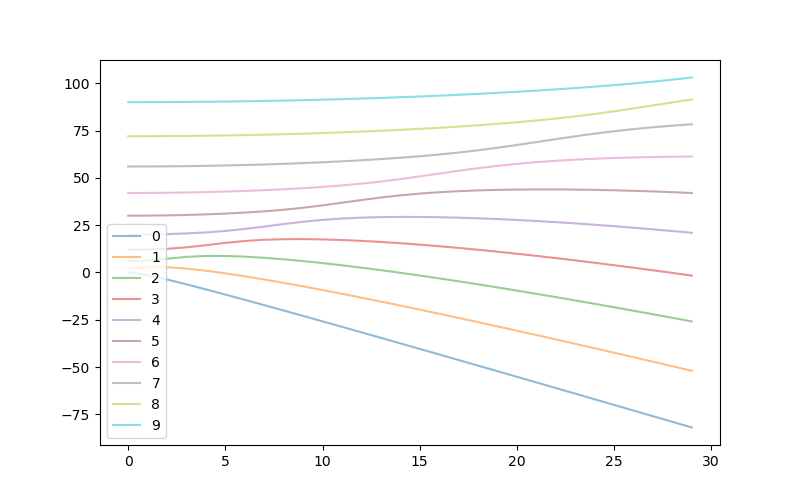

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(first_10_eigenvalues, label = range(m,m+num_to_plot), alpha = 0.5)
#ax.plot(first_10_eigenvalues_worse, label = range(m,m+num_to_plot), c = 'r', alpha = 0.5)
ax.legend()

In [13]:
def prob_sphere_harm(l, m):
  # This method returns the probability density function, P(theta),
  # of the spherical harmonic l,m where:
  #
  # l is the angular momentum quantum number
  # m is the magnetic quantum number

  return np.vectorize(lambda x: np.real(2*math.pi*(np.conjugate(scipy.special.sph_harm(m,l,0,x)))*(scipy.special.sph_harm(m,l,0,x))*math.sin(x)))

The cell below checks that the spherical harmonics from python are normalized.

In [14]:
np.sum(prob_sphere_harm(0,0)(np.arange(0,np.pi,0.00001))*0.00001)

0.99999999999654

In [15]:
def prob_psi_wrt_eigenvec(eigenvector, m):
  # This method returns the probability density function, P(theta),
  # corresponding to the eigenvector; namely this method returns a
  # function which is weighted sum of the corresponding spherical
  # harmonics, where the weights are given by the values in the eigenvector.
  #
  # eigenvector is an eigenvector of the full hamiltonian matrix
  # m is the magnetic quantum number, and determines the lowest value of l to
  # use for the spherical harmonics, and of course the m value of the spherical
  # harmonics
  
  def prob_psi(x):
    dprob = 0
    for l, val in enumerate(eigenvector):
      dprob = dprob + val*val*prob_sphere_harm(m+l,m)(x)
    return dprob

  return np.vectorize(prob_psi)

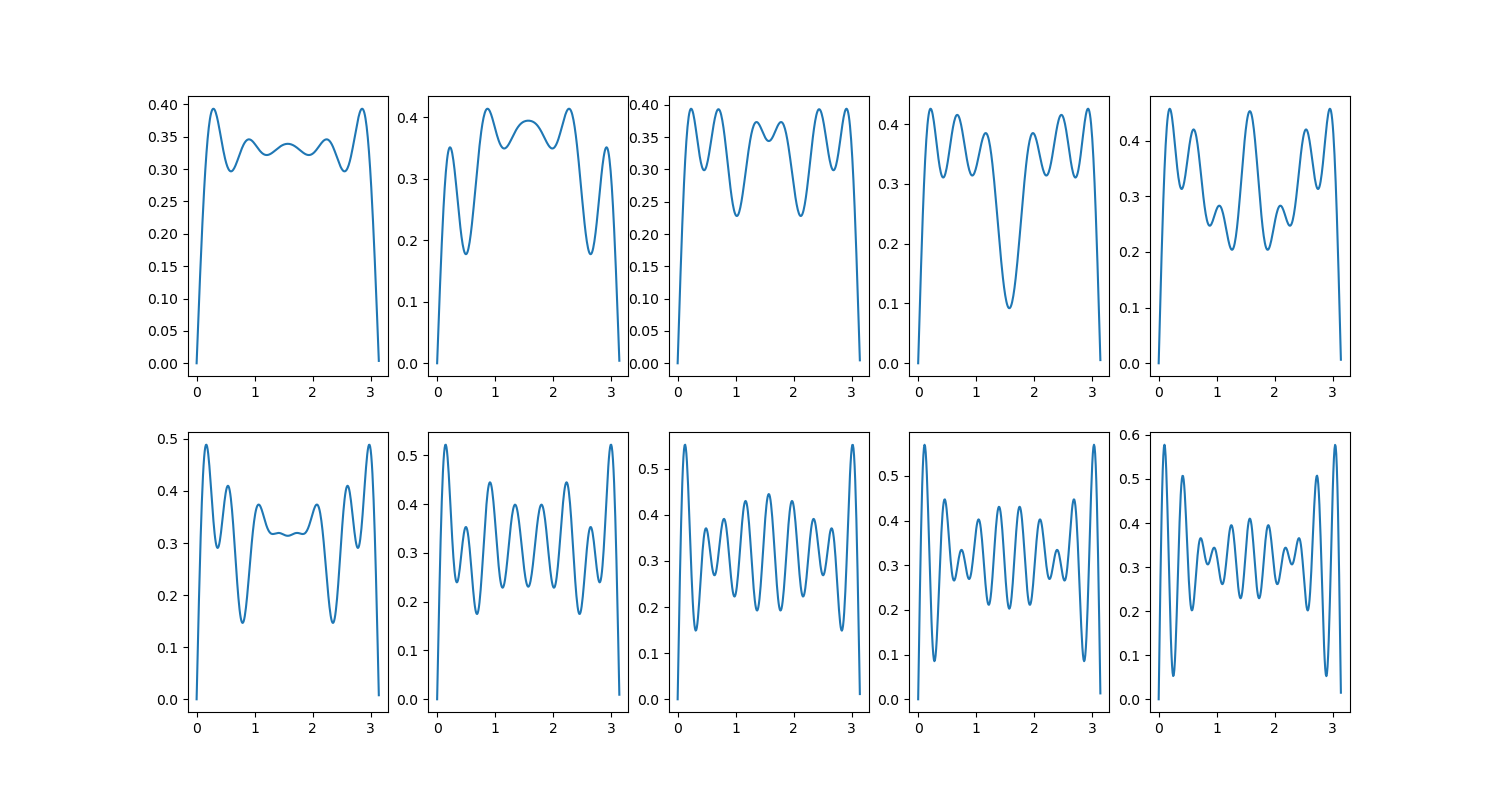

In [16]:
fig, ax = plt.subplots(2, 5, figsize=(15, 8))

E = 10

for i in range(5):
    ax[0][i].plot(np.arange(0,np.pi,0.01), prob_psi_wrt_eigenvec(eigenvectors[E][i], m)(np.arange(0,np.pi,0.01)))
for i in range(5):
    ax[1][i].plot(np.arange(0,np.pi,0.01), prob_psi_wrt_eigenvec(eigenvectors[E][5+i], m)(np.arange(0,np.pi,0.01)))

# Examples with Experimental Values

Let's examine the effect for NaCs and HF.

In [17]:
# Conversion factor for 1/cm to THz

cm_to_THz = (299792458/0.01)/(1e12)
print("1/cm to THz:", cm_to_THz)

# Conversion factor for debye in C m to THz / (N/C)

debye_in_C_m = 3.33564e-30
planks_const = 6.62607015e-34
debye_to_THz = (debye_in_C_m/planks_const)/(1e12)
print("debye to THz/(N/C):", debye_to_THz)


1/cm to THz: 0.0299792458
debye to THz/(N/C): 5.034115130821548e-09


In [18]:
dim = 50
m = 0

# rotational constant in 1/cm converted to THz
B_HF = 20.9557*cm_to_THz
B_NaCs = 0.058*cm_to_THz

# dipole moment in Debye converted to THz / (N/C)
d_HF = 1.826*debye_to_THz
d_NaCs = 4.69*debye_to_THz

Examining high E-field results

In [19]:
# setting up E-field range
E_min = 0
E_max = 10e8

interval = 60
E_step = int(E_max/interval)

In [20]:
E_range = range(E_min,int(E_max),E_step)

In [21]:
Efield_eigenstates_HF = get_eigenstates_for_E_range(E_min = E_min, 
                                                    E_max = int(E_max), 
                                                    E_step = E_step, 
                                                    dim = dim, 
                                                    B = B_HF, 
                                                    d = d_HF,
                                                    m = m)
eigenvalues_HF = [[value[0] for value in array] for array in Efield_eigenstates_HF.values()]
eigenvectors_HF = [[value[1] for value in array] for array in Efield_eigenstates_HF.values()]

In [22]:
num = 10
first_num_eigenvalues_HF = [vals[:num] for vals in eigenvalues_HF]

Low field seeking vs high field seeking

Text(0.5, 1.0, 'Rotational Energy Levels for HF - E-field 10^9 N/C')

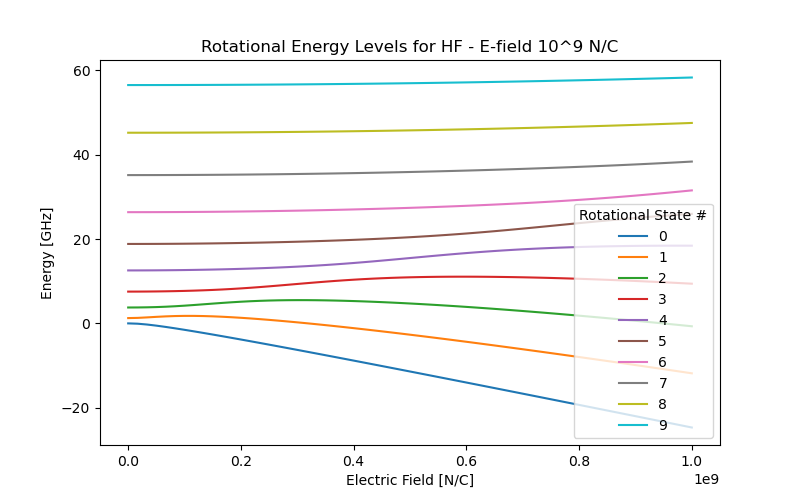

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(E_range, first_num_eigenvalues_HF, label = range(m,m+num))
ax.set_ylabel("Energy [GHz]")
ax.set_xlabel("Electric Field [N/C]")
ax.legend(title="Rotational State #")
ax.set_title("Rotational Energy Levels for HF - E-field 10^9 N/C")

In [24]:
Efield_eigenstates_NaCs = get_eigenstates_for_E_range(E_min = E_min, 
                                                    E_max = int(E_max), 
                                                    E_step = E_step, 
                                                    dim = dim, 
                                                    B = B_NaCs, 
                                                    d = d_NaCs,
                                                    m = m)
eigenvalues_NaCs = [[value[0] for value in array] for array in Efield_eigenstates_NaCs.values()]
eigenvectors_NaCs = [[value[1] for value in array] for array in Efield_eigenstates_NaCs.values()]

In [25]:
num = 10
first_num_eigenvalues_NaCs = [vals[:num] for vals in eigenvalues_NaCs]

Text(0.5, 1.0, 'Rotational Energy Levels for NaCs - E-field 10^9 N/C')

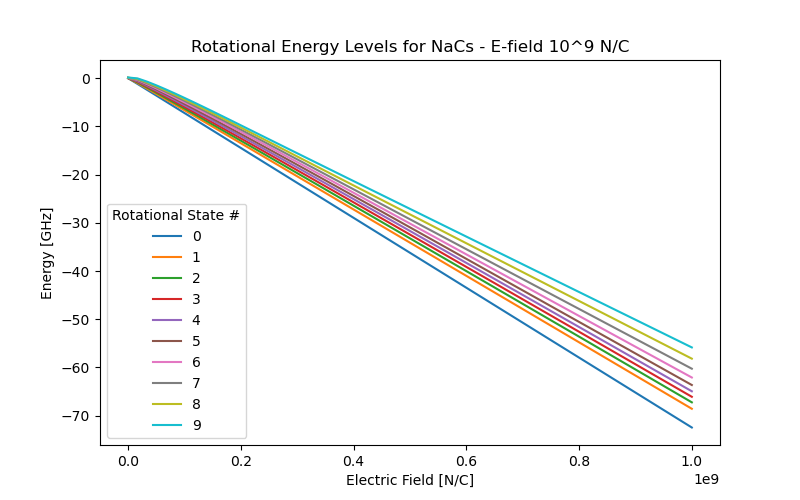

In [26]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(E_range, first_num_eigenvalues_NaCs, label = range(m,m+num))
ax.set_ylabel("Energy [GHz]")
ax.set_xlabel("Electric Field [N/C]")
ax.legend(title="Rotational State #")
ax.set_title("Rotational Energy Levels for NaCs - E-field 10^9 N/C")

Examining low E-field results

In [27]:
# setting up E-field range
E_min = 0
E_max = 10e5

interval = 60
E_step = int(E_max/interval)

In [28]:
E_range = range(E_min,int(E_max),E_step)

In [29]:
Efield_eigenstates_HF = get_eigenstates_for_E_range(E_min = E_min, 
                                                    E_max = int(E_max), 
                                                    E_step = E_step, 
                                                    dim = dim, 
                                                    B = B_HF, 
                                                    d = d_HF,
                                                    m = m)
eigenvalues_HF = [[value[0] for value in array] for array in Efield_eigenstates_HF.values()]
eigenvectors_HF = [[value[1] for value in array] for array in Efield_eigenstates_HF.values()]

In [30]:
num = 10
first_num_eigenvalues_HF = [vals[:num] for vals in eigenvalues_HF]

Text(0.5, 1.0, 'Rotational Energy Levels for HF - E-field 10^6 N/C')

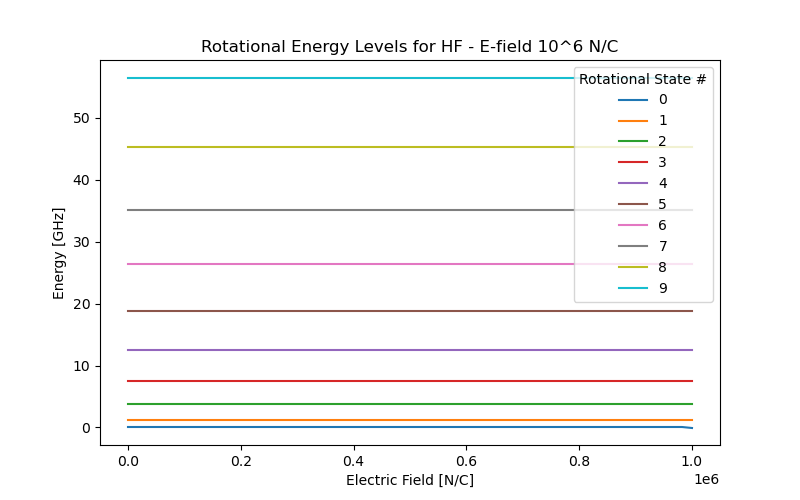

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(E_range, first_num_eigenvalues_HF, label = range(m,m+num))
ax.set_ylabel("Energy [GHz]")
ax.set_xlabel("Electric Field [N/C]")
ax.legend(title="Rotational State #")
ax.set_title("Rotational Energy Levels for HF - E-field 10^6 N/C")

In [32]:
Efield_eigenstates_NaCs = get_eigenstates_for_E_range(E_min = E_min, 
                                                    E_max = int(E_max), 
                                                    E_step = E_step, 
                                                    dim = dim, 
                                                    B = B_NaCs, 
                                                    d = d_NaCs,
                                                    m = m)
eigenvalues_NaCs = [[value[0] for value in array] for array in Efield_eigenstates_NaCs.values()]
eigenvectors_NaCs = [[value[1] for value in array] for array in Efield_eigenstates_NaCs.values()]

In [33]:
num = 10
first_num_eigenvalues_NaCs = [vals[:num] for vals in eigenvalues_NaCs]

Text(0.5, 1.0, 'Rotational Energy Levels for NaCs - E-field 10^6 N/C')

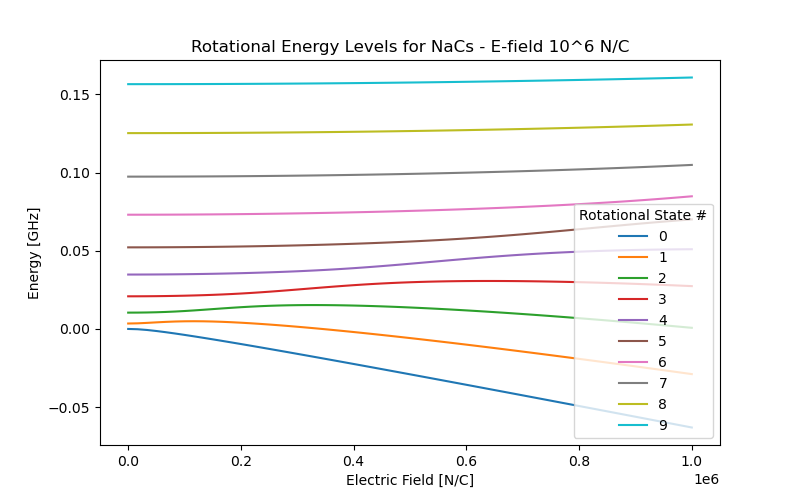

In [34]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(E_range, first_num_eigenvalues_NaCs, label = range(m,m+num))
ax.set_ylabel("Energy [GHz]")
ax.set_xlabel("Electric Field [N/C]")
ax.legend(title="Rotational State #")
ax.set_title("Rotational Energy Levels for NaCs - E-field 10^6 N/C")